In [ ]:
from fastai import *        # Quick access to most common functionality
from fastai.text import *   # Quick access to NLP functionality
from pathlib import Path

In [ ]:
#Naive Bayes (baseline)

In [38]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import KFold
import os
from sklearn.metrics import accuracy_score
import pandas as pd
import sys

file_path = '/home/ubuntu/data/autopsy/data.csv'


data = pd.read_csv(file_path,
                          header=None, encoding='ISO-8859-1',
                          names=['label', 'text'])

data = data.loc[data['label'].isin(['Suicide','Homicide'])]
data.label = pd.Categorical(data.label)
data['label_code'] = data.label.cat.codes


X = data['text'].values

Y = data['label_code'].values
print(Y)
print(data['label'].values)

kfold_splits = 5
kf = StratifiedKFold(n_splits=kfold_splits, shuffle=True, random_state=42)

history = []
for index, (train_indices, test_indices) in enumerate(kf.split(data['text'],data['label'])):
  xtrain, xtest = X[train_indices], X[test_indices]
  ytrain, ytest = Y[train_indices], Y[test_indices]


  vectorizer = CountVectorizer(stop_words='english')
  
  train_features = vectorizer.fit_transform(xtrain)
  test_features = vectorizer.transform(xtest)
  

  nb = MultinomialNB()
  nb.fit(train_features, ytrain)


  predictions = nb.predict(test_features)
  accuracy = accuracy_score(ytest,predictions)
  history.append(accuracy)
  print (accuracy)
print(history)

sum = 0.0
for acc in history:
  sum = sum + acc
print ('average accuracy:', (sum/(kfold_splits)))

[1 1 0 0 ... 1 1 1 1]
[Suicide, Suicide, Homicide, Homicide, Suicide, ..., Homicide, Suicide, Suicide, Suicide, Suicide]
Length: 1293
Categories (2, object): [Homicide, Suicide]
0.8416988416988417
0.8262548262548263
0.8532818532818532
0.8841698841698842
0.8365758754863813
[0.8416988416988417, 0.8262548262548263, 0.8532818532818532, 0.8841698841698842, 0.8365758754863813]
average accuracy: 0.8483962561783572


In [ ]:
#Basic RNN LSTM (baseline)

In [40]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.python.keras.layers import Input, LSTM, Bidirectional, Dense, Embedding, Dropout, SpatialDropout1D, GRU
from keras import optimizers
import sys

from sklearn.model_selection import StratifiedKFold

import pandas as pd
import re
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import KFold
import os

file_path = '/home/ubuntu/data/autopsy/data.csv'


data = pd.read_csv(file_path,
                          header=None, encoding='ISO-8859-1',
                          names=['label', 'text'])

data = data.loc[data['label'].isin(['Suicide','Homicide'])]
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['label']).values

print(Y.shape)
print(X.shape)



maxlen = X.shape[1]
embedding_size=300
batch_size = 32
lstm_out = 196
epochs = 20

def make_model(batch_size=None):
  source = Input(shape=(maxlen,), batch_size=batch_size, dtype=tf.int32, name='Input')
  embedding = Embedding(input_dim=max_features, output_dim=embedding_size, input_length = X.shape[1],name='Embedding')(source)
  drop = SpatialDropout1D(0.5)(embedding)
  #rnn =  Bidirectional(LSTM(lstm_out, name = 'LSTM',dropout=0.50, recurrent_dropout=0.50))(drop)
  rnn =  LSTM(lstm_out, name = 'LSTM',dropout=0.40, recurrent_dropout=0.40)(drop)
  predicted_var = Dense(2, activation='sigmoid', name='Output')(rnn)
  model = tf.keras.Model(inputs=[source], outputs=[predicted_var])
  model.compile(
      optimizer='adam',
      #optimizer=tf.keras.optimizers.RMSprop(decay=1e-3),
      loss = 'categorical_crossentropy',
      metrics=['acc'])
  return model

history_list = []

eval_history_list = []

kfold_splits = 5
kf = KFold(n_splits=kfold_splits, shuffle=True)

for index, (train_indices, val_indices) in enumerate(kf.split(data['text'],data['label'])):
  xtrain, xval = X[train_indices], X[val_indices]
  ytrain, yval = Y[train_indices], Y[val_indices]
  
  tf.keras.backend.clear_session()
  training_model = None
  #training_model = make_model(batch_size = batch_size)
  training_model = make_model()
  
  
  history = training_model.fit(xtrain, ytrain,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(xval,yval))
  
  history_list.append(history)

  accuracy_history = history.history['acc']
  val_accuracy_history = history.history['val_acc']
  print ("Last training accuracy: " + str(accuracy_history[-1]) + ", last validation accuracy: " + str(val_accuracy_history[-1]) )
  
  eval_history = training_model.evaluate(xval, yval, batch_size=batch_size)
  eval_history_list.append(eval_history[1])

  print ("Evaluate:")
  print(eval_history)
 
sum = 0.0
for h in history_list:
  val_accuracy_history = h.history['val_acc']
  final_val_accuracy = val_accuracy_history[-1]
  sum = sum + final_val_accuracy

print('')
print(eval_history_list)
print('')
print("average accuracy:", (sum/(kfold_splits)))


(1293, 2)
(1293, 2961)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1034 samples, validate on 259 samples
Epoch 1/20
 192/1034 [====>.........................] - ETA: 4:21 - loss: 0.6878 - acc: 0.6250

KeyboardInterrupt: 

In [ ]:
#Simple RNN using an AWD LSTM activation (trained from scratch)

In [12]:
path_clas = Path('/home/ubuntu/data/autopsy')

batch_size=32
epochs=20
drop_mult=0.1
learning_rate=1e-3
wd=1e-4
num_folds = 5

folds = ['data_suicide_homicide_k_1.csv','data_suicide_homicide_k_2.csv','data_suicide_homicide_k_3.csv','data_suicide_homicide_k_4.csv','data_suicide_homicide_k_5.csv']

accuracy_list = []
learner_list = []
i = 0
for f in folds:
  i = i + 1
  print("\nFold: " + str(i))
  data_clas = TextClasDataBunch.from_csv(path_clas,f, max_vocab=2000, classes=['Suicide','Homicide'], bs=batch_size)

  learn = text_classifier_learner(data_clas, drop_mult=drop_mult, emb_sz=300, nh=198, nl=1)
  learn.unfreeze()
  learn.fit(epochs,learning_rate, wd=wd)
  learner_list.append(learn)

  acc = (learn.validate())[1].item()
  accuracy_list.append(acc)

print('\nAccuracy List')
print(accuracy_list)

print("\nAverage Accuracy")
print( (sum(accuracy_list))/ (float(num_folds)  ))



Accuracy List
[0.9111968874931335, 0.9305019378662109, 0.9111968874931335, 0.9305019378662109, 0.92277991771698]

Average Accuracy
0.9212355136871337


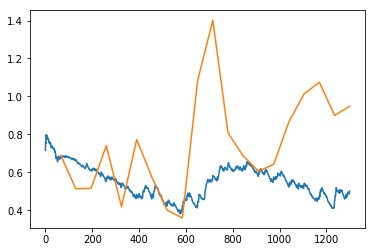

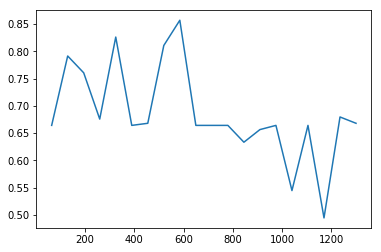

In [20]:
learner_list[0].recorder.plot_losses()
learner_list[0].recorder.plot_metrics()

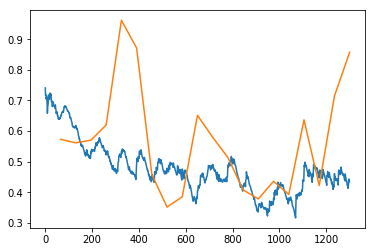

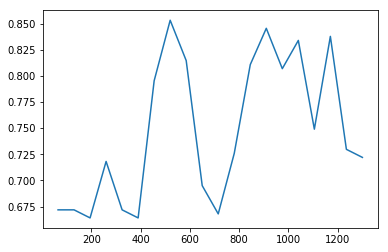

In [19]:
learner_list[1].recorder.plot_losses()
learner_list[1].recorder.plot_metrics()

In [ ]:
#Large RNN using an AWD LSTM activation (trained from scratch)

In [18]:
path_clas = Path('/home/ubuntu/data/autopsy')

batch_size=32
epochs=20
drop_mult=0.9
learning_rate=1e-3
wd=1e-4
num_folds = 5

folds = ['data_suicide_homicide_k_1.csv','data_suicide_homicide_k_2.csv','data_suicide_homicide_k_3.csv','data_suicide_homicide_k_4.csv','data_suicide_homicide_k_5.csv']

accuracy_list = []
learner_list = []
i = 0
for f in folds:
  i = i + 1
  print("\nFold: " + str(i))
  data_clas = TextClasDataBunch.from_csv(path_clas,f, classes=['Suicide','Homicide'],bs=batch_size)

  learn = text_classifier_learner(data_clas, drop_mult=drop_mult)
  learn.unfreeze()
  learn.fit(epochs,learning_rate, wd=wd)
  learner_list.append(learn)
  
  acc = (learn.validate())[1].item()
  accuracy_list.append(acc)

print('\nAccuracy List')
print(accuracy_list)

print("\nAverage Accuracy")
print( (sum(accuracy_list))/ (float(num_folds)  ))



Accuracy List
[0.6679536700248718, 0.7220077514648438, 0.837837815284729, 0.8571428656578064, 0.8108108043670654]

Average Accuracy
0.7791505813598633


In [ ]:
learner_list[0].recorder.plot_losses()
learner_list[0].recorder.plot_metrics()

In [ ]:
learner_list[1].recorder.plot_losses()
learner_list[1].recorder.plot_metrics()

In [ ]:
#Large RNN using an AWD LSTM activation (pretrained with WikiText)

In [32]:
path_clas = Path('/home/ubuntu/data/autopsy')
path_lm = Path('/home/ubuntu/data/autopsy')

batch_size=32
epochs=20
drop_mult=0.1
learning_rate=1e-3
wd=1e-4
num_folds = 5

folds = ['data_suicide_homicide_k_1.csv','data_suicide_homicide_k_2.csv','data_suicide_homicide_k_3.csv','data_suicide_homicide_k_4.csv','data_suicide_homicide_k_5.csv']

accuracy_list = []
learner_list = []
i = 0
data_lm = TextLMDataBunch.from_csv(path_lm, 'data_suicide_homicide_k_1.csv', classes=['Suicide','Homicide'])
for f in folds:
  i = i + 1
  print("\nFold: " + str(i))
  #data_lm = TextLMDataBunch.from_csv(path_lm, f, classes=['Suicide','Homicide'])
  data_clas = TextClasDataBunch.from_csv(path_clas,f, vocab=data_lm.train_ds.vocab, classes=['Suicide','Homicide'], bs=batch_size)

  learn = text_classifier_learner(data_clas, drop_mult=drop_mult)
  learn.load_encoder('enc_autopsy_only_pretrained')
  learn.fit(4,learning_rate, wd=wd)
  learn.unfreeze()
  learn.fit(epochs,learning_rate, wd=wd)
  learner_list.append(learn)
  
  acc = (learn.validate())[1].item()
  accuracy_list.append(acc)

print('\nAccuracy List')
print(accuracy_list)

print("\nAverage Accuracy")
print( (sum(accuracy_list))/ (float(num_folds)  ))



Accuracy List
[0.9343629479408264, 0.9266409277915955, 0.915057897567749, 0.9266409277915955, 0.9034749269485474]

Average Accuracy
0.9212355256080628


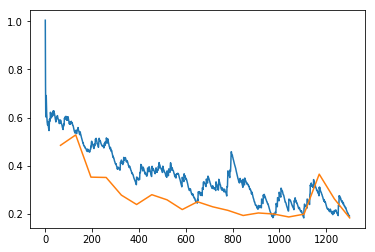

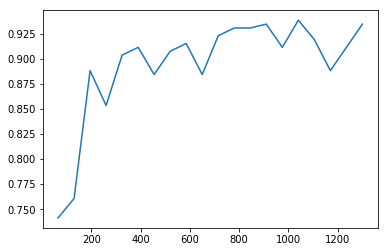

In [33]:
learner_list[0].recorder.plot_losses()
learner_list[0].recorder.plot_metrics()

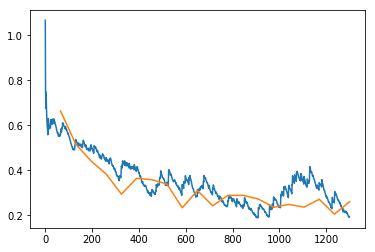

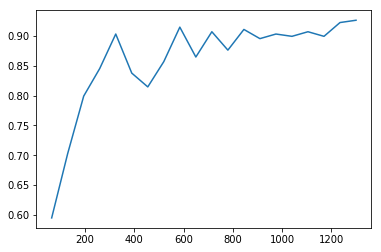

In [34]:
learner_list[1].recorder.plot_losses()
learner_list[1].recorder.plot_metrics()

In [ ]:
#Large RNN using an AWD LSTM activation (finetuned with the autopsy data)

In [29]:
path_clas = Path('/home/ubuntu/data/autopsy')
path_lm = Path('/home/ubuntu/data/autopsy')

batch_size=32
epochs=20
drop_mult=0.1
learning_rate=1e-3
wd=1e-4
num_folds = 5

folds = ['data_suicide_homicide_k_1.csv','data_suicide_homicide_k_2.csv','data_suicide_homicide_k_3.csv','data_suicide_homicide_k_4.csv','data_suicide_homicide_k_5.csv']

accuracy_list = []
learner_list = []

i = 0
data_lm = TextLMDataBunch.from_csv(path_lm, 'data_suicide_homicide_k_1.csv', classes=['Suicide','Homicide'])
for f in folds:
  i = i + 1
  
  #data_lm = TextLMDataBunch.from_csv(path_lm, 'data_suicide_homicide_k_1.csv', classes=['Suicide','Homicide'])

  data_clas = TextClasDataBunch.from_csv(path_clas,f, vocab=data_lm.train_ds.vocab, classes=['Suicide','Homicide'], bs=batch_size)

  learn = text_classifier_learner(data_clas, drop_mult=drop_mult)
  learn.load_encoder('enc_autopsy_not_pretrained')
  learn.fit(4,learning_rate, wd=wd)
  learn.unfreeze()
  learn.fit(epochs,learning_rate, wd=wd)
  learner_list.append(learn)
  
  acc = (learn.validate())[1].item()
  accuracy_list.append(acc)

print('\nAccuracy List')
print(accuracy_list)

print("\nAverage Accuracy")
print( (sum(accuracy_list))/ (float(num_folds)  ))



Accuracy List
[0.2664092779159546, 0.3706563711166382, 0.7915058135986328, 0.6370656490325928, 0.5405405163764954]

Average Accuracy
0.5212355256080627
['xxunk', 'xxpad', '\n', 'cm', '.', 'left', 'right', 'wound', '1', '0']
['xxunk', 'xxpad', '\n', 'cm', '.', 'left', 'right', 'wound', '1', '0']
['xxunk', 'xxpad', '\n', 'cm', '.', 'left', 'right', 'wound', '1', '0']
['xxunk', 'xxpad', '\n', 'cm', '.', 'left', 'right', 'wound', '1', '0']
['xxunk', 'xxpad', '\n', 'cm', '.', 'left', 'right', 'wound', '1', '0']


In [ ]:
learner_list[0].recorder.plot_losses()
learner_list[0].recorder.plot_metrics()

In [ ]:
learner_list[1].recorder.plot_losses()
learner_list[1].recorder.plot_metrics()

In [ ]:
#Large RNN using an AWD LSTM activation (finetuned with the Nidia27k data)

In [35]:
path_clas = Path('/home/ubuntu/data/autopsy')
path_lm = Path('/home/ubuntu/data/medical/nidia27k_preprocess')

batch_size=32
epochs=20
drop_mult=0.1
learning_rate=1e-3
wd=1e-4
num_folds = 5

folds = ['data_suicide_homicide_k_1.csv','data_suicide_homicide_k_2.csv','data_suicide_homicide_k_3.csv','data_suicide_homicide_k_4.csv','data_suicide_homicide_k_5.csv']

accuracy_list = []
learner_list = []
i = 0
data_lm = TextLMDataBunch.from_csv(path_lm,'documents-preprocess-valid.csv', classes=['neg','pos'], bs=batch_size)
for f in folds:
  i = i + 1
  print("\nFold: " + str(i))
  #data_lm = TextLMDataBunch.from_csv(path_lm, f, classes=['Suicide','Homicide'])
  #data_lm = TextLMDataBunch.from_csv(path_lm,'documents-preprocess-valid.csv', classes=['neg','pos'], bs=batch_size)
  data_clas = TextClasDataBunch.from_csv(path_clas,f, vocab=data_lm.train_ds.vocab, classes=['Suicide','Homicide'], bs=batch_size)

  learn = text_classifier_learner(data_clas, drop_mult=drop_mult)
  learn.load_encoder('enc_nidia_not_pretrained')
  learn.fit(4,learning_rate, wd=wd)
  learn.unfreeze()
  learn.fit(epochs,learning_rate, wd=wd)
  
  learner_list.append(learn)  
    
  acc = (learn.validate())[1].item()
  accuracy_list.append(acc)

print('\nAccuracy List')
print(accuracy_list)

print("\nAverage Accuracy")
print( (sum(accuracy_list))/ (float(num_folds)  ))


Accuracy List
[0.6911196708679199, 0.7181467413902283, 0.8108108043670654, 0.7142857313156128, 0.84555983543396]

Average Accuracy
0.7559845566749572


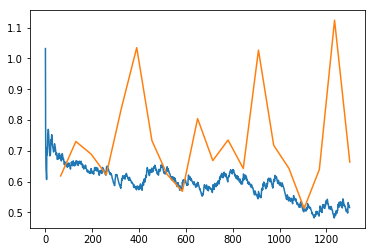

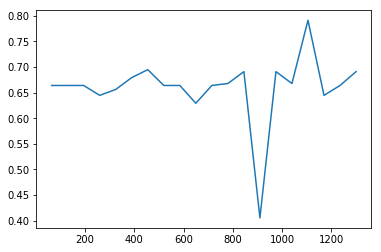

In [36]:
learner_list[0].recorder.plot_losses()
learner_list[0].recorder.plot_metrics()

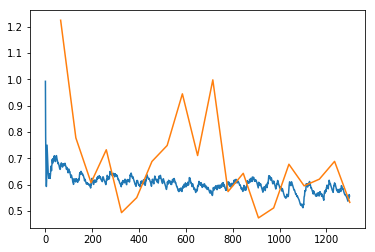

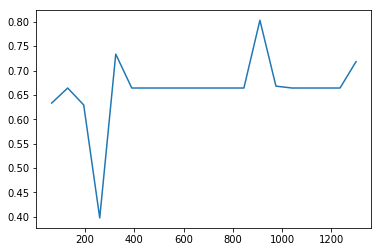

In [37]:
learner_list[1].recorder.plot_losses()
learner_list[1].recorder.plot_metrics()

In [ ]:
#Large RNN using an AWD LSTM activation (pretrained with WikiText and finetuned with the autopsy data)

In [ ]:
path_clas = Path('/home/ubuntu/data/autopsy')
path_lm = Path('/home/ubuntu/data/autopsy')

batch_size=32
epochs=20
drop_mult=0.1
learning_rate=1e-3
wd=1e-4
num_folds = 5

folds = ['data_suicide_homicide_k_1.csv','data_suicide_homicide_k_2.csv','data_suicide_homicide_k_3.csv','data_suicide_homicide_k_4.csv','data_suicide_homicide_k_5.csv']

accuracy_list = []
learner_list = []
i = 0
data_lm = TextLMDataBunch.from_csv(path_lm, 'data_suicide_homicide_k_1.csv', classes=['Suicide','Homicide'])
for f in folds:
  i = i + 1
  print("\nFold: " + str(i))
  #data_lm = TextLMDataBunch.from_csv(path_lm, f, classes=['Suicide','Homicide'])
  data_clas = TextClasDataBunch.from_csv(path_clas,f, vocab=data_lm.train_ds.vocab, classes=['Suicide','Homicide'], bs=batch_size)

  learn = text_classifier_learner(data_clas, drop_mult=drop_mult)
  learn.load_encoder('enc_autopsy_pretrained')
  learn.fit(4,learning_rate, wd=wd)
  learn.unfreeze()
  learn.fit(epochs,learning_rate, wd=wd)
  learner_list.append(learn)
  
  acc = (learn.validate())[1].item()
  accuracy_list.append(acc)

print('\nAccuracy List')
print(accuracy_list)

print("\nAverage Accuracy")
print( (sum(accuracy_list))/ (float(num_folds)  ))


In [ ]:
learner_list[0].recorder.plot_losses()
learner_list[0].recorder.plot_metrics()

In [ ]:
learner_list[1].recorder.plot_losses()
learner_list[1].recorder.plot_metrics()

In [ ]:
#Large RNN using an AWD LSTM activation (pretrained with WikiText and finetuned with the Nidia27k data)

In [ ]:
path_clas = Path('/home/ubuntu/data/autopsy')
path_lm = Path('/home/ubuntu/data/medical/nidia27k_preprocess')

batch_size=32
epochs=20
drop_mult=0.1
learning_rate=1e-3
wd=1e-4
num_folds = 5

folds = ['data_suicide_homicide_k_1.csv','data_suicide_homicide_k_2.csv','data_suicide_homicide_k_3.csv','data_suicide_homicide_k_4.csv','data_suicide_homicide_k_5.csv']

accuracy_list = []
learner_list = []
i = 0
data_lm = TextLMDataBunch.from_csv(path_lm, 'documents-preprocess-valid.csv', classes=['neg','pos'])
for f in folds:
  i = i + 1
  print("\nFold: " + str(i))
  #data_lm = TextLMDataBunch.from_csv(path_lm, f, classes=['neg','pos'])
  data_clas = TextClasDataBunch.from_csv(path_clas,f, vocab=data_lm.train_ds.vocab, classes=['Suicide','Homicide'],bs=batch_size)

  learn = text_classifier_learner(data_clas, drop_mult=drop_mult)
  learn.load_encoder('enc_nidia_pretrained')
  learn.fit(4,learning_rate, wd=wd)
  learn.unfreeze()
  learn.fit(epochs,learning_rate, wd=wd)
  learner_list.append(learn)
  
  acc = (learn.validate())[1].item()
  accuracy_list.append(acc)

print('\nAccuracy List')
print(accuracy_list)

print("\nAverage Accuracy")
print( (sum(accuracy_list))/ (float(num_folds)  ))

In [ ]:
learner_list[0].recorder.plot_losses()
learner_list[0].recorder.plot_metrics()

In [ ]:
learner_list[0].recorder.plot_losses()
learner_list[0].recorder.plot_metrics()